In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0) # if 0 doesn't work for you try replacing it with one.
# this piece of code will help us access the camera and click ramdom 30 images, once that is done it will save those images to a folder named:
# data=> images which you will have to create manually.

for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [15]:
!labelme
# it will run the labelme application through which you will manually label the images as this is a practice project for me so I choose to label the images manually

^C


In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [16]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [17]:
tf.config.list_physical_devices('GPU')

[]

In [18]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [19]:
images.as_numpy_iterator().next()


b'data\\images\\9eda03bc-b89e-11ee-bf38-94e23c5bdb04.jpg'

In [20]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [21]:
images = images.map(load_image)

In [22]:
images.as_numpy_iterator().next()

array([[[28, 44, 34],
        [27, 43, 33],
        [26, 43, 35],
        ...,
        [27, 36, 31],
        [26, 35, 30],
        [26, 36, 28]],

       [[29, 45, 35],
        [28, 44, 34],
        [27, 44, 36],
        ...,
        [28, 37, 32],
        [26, 35, 30],
        [25, 35, 27]],

       [[30, 45, 38],
        [29, 44, 37],
        [27, 44, 38],
        ...,
        [31, 37, 33],
        [26, 35, 30],
        [25, 35, 27]],

       ...,

       [[20, 20, 20],
        [21, 21, 21],
        [21, 21, 21],
        ...,
        [55, 56, 40],
        [55, 56, 40],
        [54, 55, 39]],

       [[20, 20, 20],
        [20, 20, 20],
        [21, 21, 21],
        ...,
        [56, 57, 41],
        [56, 57, 39],
        [55, 56, 38]],

       [[20, 20, 20],
        [21, 21, 21],
        [21, 21, 21],
        ...,
        [57, 58, 42],
        [57, 58, 40],
        [56, 57, 39]]], dtype=uint8)

In [23]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [24]:
image_generator = images.batch(4).as_numpy_iterator()

In [25]:
plot_images = image_generator.next()

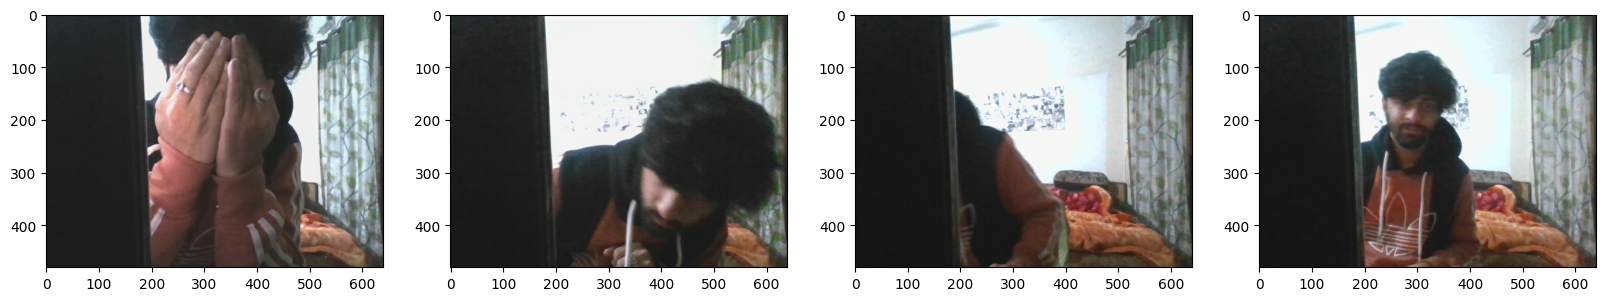

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [41]:
#Partition Unaugmented Data

for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [36]:
# Apply Image Augmentation on Images and Labels using Albumentations

import albumentations as alb

# setting up the pipeline 

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))


In [38]:
# the way we have split the data=> 90*.7 # 63 to train  90*.15 # 14 and 13 to test and val
# Load a Test Image and Annotation with OpenCV and JSON
img = cv2.imread(os.path.join('data','train', 'images','1fe7b08b-b89c-11ee-9d89-94e23c5bdb04.jpg'))


In [42]:
with open(os.path.join('data', 'train', 'labels', '1fe7b08b-b89c-11ee-9d89-94e23c5bdb04.json'), 'r') as f:
    label = json.load(f)

In [43]:
label['shapes'][0]['points']

[[191.15384615384616, 59.230769230769255],
 [308.46153846153845, 247.6923076923077]]

In [44]:
#  Extract Coordinates and Rescale to Match Image Resolution

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [45]:
coords

[191.15384615384616, 59.230769230769255, 308.46153846153845, 247.6923076923077]

In [46]:
coords = list(np.divide(coords, [640,480,640,480]))

In [47]:
coords

[0.29867788461538464,
 0.12339743589743594,
 0.48197115384615385,
 0.5160256410256411]

In [48]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [49]:
augmented['bboxes'][0][2:]

(0.31435897435897436, 0.5037606837606838)

In [50]:
augmented['bboxes']

[(0.05367521367521369,
  0.08495726495726501,
  0.31435897435897436,
  0.5037606837606838)]

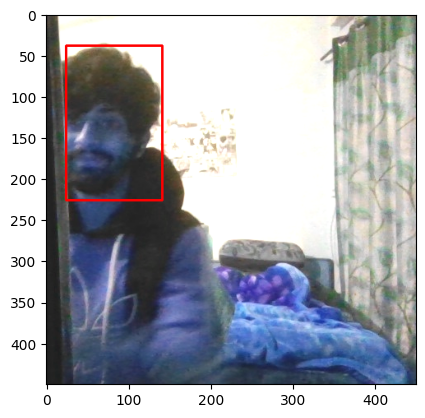

In [51]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [54]:
# Build and Run Augmentation Pipeline

   # Run Augmentation Pipeline:

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                # aug_data will be a new folder that you will create which will have similar folders like the folder data
                # you will create this folder next to the folder data not inside it.
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [55]:
# Load Augmented Images to Tensorflow Dataset
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image) # compressing the data even more
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [56]:
train_images.as_numpy_iterator().next()

array([[[0.35661766, 0.1569853 , 0.07984069],
        [0.39031863, 0.18253677, 0.12254902],
        [0.3346201 , 0.15343137, 0.1091299 ],
        ...,
        [0.07058824, 0.07058824, 0.07058824],
        [0.06844363, 0.06844363, 0.06844363],
        [0.06813726, 0.06813726, 0.06813726]],

       [[0.54289216, 0.28713235, 0.1829044 ],
        [0.50281864, 0.28321078, 0.18504901],
        [0.34258577, 0.16354166, 0.08713235],
        ...,
        [0.07058824, 0.07058824, 0.07058824],
        [0.07058824, 0.07058824, 0.07058824],
        [0.07058824, 0.07058824, 0.07058824]],

       [[0.5251225 , 0.2810049 , 0.12267157],
        [0.5964461 , 0.34068626, 0.19460784],
        [0.55      , 0.2887255 , 0.17598039],
        ...,
        [0.06666667, 0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667],
        [0.07040441, 0.07040441, 0.07040441]],

       ...,

       [[0.55447304, 0.5829044 , 0.6059436 ],
        [0.5067402 , 0.54987746, 0.5665441 ],
        [0.46194854, 0

In [57]:
# Prepare Labels => Build Label Loading Function
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [58]:
# Load Labels to Tensorflow Dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [59]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.538 , 0.433 , 0.7905, 0.8687], dtype=float16))

In [60]:
# Combine Label and Image Samples => Check Partition Lengths

len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(3780, 3780, 840, 840, 780, 780)

In [61]:
# Create Final Datasets (Images/Labels)

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [73]:
#View Images and Annotations
data_samples = train.as_numpy_iterator()


In [77]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


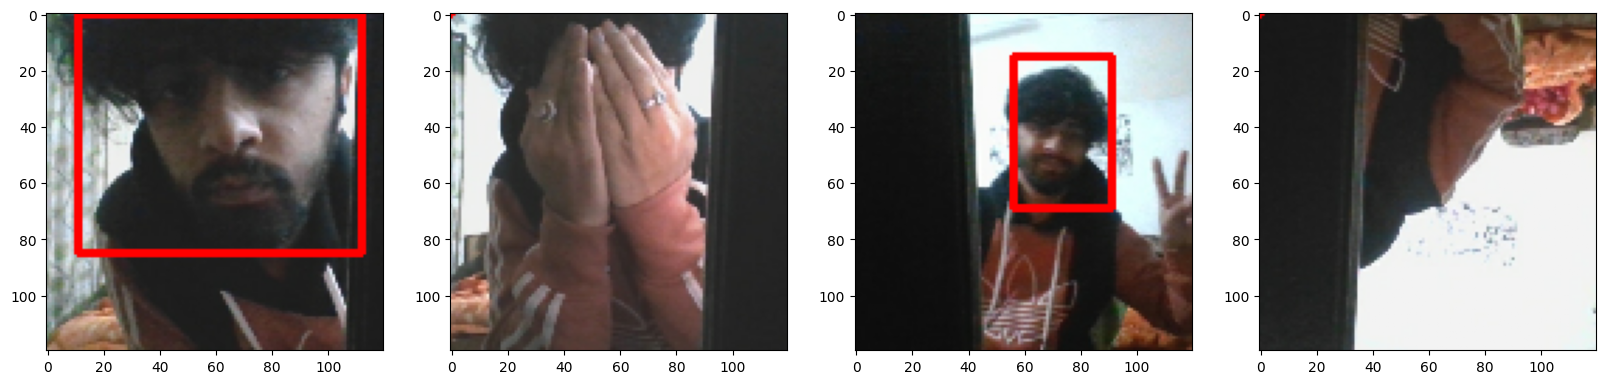

In [78]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = res[0][idx].copy()  # Create a copy to avoid modifying the original array
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)


In [79]:
# Build Deep Learning using the Functional API=> Import Layers and Base Network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [80]:
vgg = VGG16(include_top=False)



58889256/58889256 [==============================] - 60s 1us/step


In [81]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [82]:
# Build instance of Network
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [83]:
# Test out Neural Network

facetracker = build_model()
facetracker.summary()

X, y = train.as_numpy_iterator().next()

X.shape

classes, coords = facetracker.predict(X)
classes, coords

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

(array([[0.47599095],
        [0.4210458 ],
        [0.47998965],
        [0.4977962 ],
        [0.50453955],
        [0.448921  ],
        [0.46361446],
        [0.4858334 ]], dtype=float32),
 array([[0.42416948, 0.39384824, 0.3781994 , 0.4098543 ],
        [0.42581162, 0.43438601, 0.32160535, 0.31278738],
        [0.49372163, 0.33863682, 0.36228192, 0.33648178],
        [0.42816222, 0.36881134, 0.3119943 , 0.38318086],
        [0.46217415, 0.33970672, 0.27887303, 0.42804846],
        [0.4583672 , 0.38272306, 0.3293281 , 0.3973603 ],
        [0.4935373 , 0.48530838, 0.31499293, 0.32238835],
        [0.4229055 , 0.46946138, 0.34271818, 0.39843982]], dtype=float32))

In [85]:
# Define Losses and Optimizers=>  Define Optimizer and LR

batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [87]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [88]:
# Create Localization Loss and Classification Loss
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [89]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [90]:
# Test out Loss Metrics

localization_loss(y[1], coords)
classloss(y[0], classes)
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7162914>

In [91]:
# Train Neural Network => Create Custom Model Class
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [92]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [94]:
# Train

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [95]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 319s 668ms/step - total_loss: 0.1114 - class_loss: 0.0276 - regress_loss: 0.0976 - val_total_loss: 8.2264e-04 - val_class_loss: 1.4092e-04 - val_regress_loss: 7.5218e-04
Epoch 2/10
473/473 [==============================] - 315s 660ms/step - total_loss: 0.0257 - class_loss: 0.0029 - regress_loss: 0.0242 - val_total_loss: 0.0058 - val_class_loss: 5.5165e-04 - val_regress_loss: 0.0056
Epoch 3/10
473/473 [==============================] - 287s 601ms/step - total_loss: 0.0366 - class_loss: 0.0060 - regress_loss: 0.0336 - val_total_loss: 0.0011 - val_class_loss: 4.0649e-04 - val_regress_loss: 8.8464e-04
Epoch 4/10
473/473 [==============================] - 286s 601ms/step - total_loss: 0.0131 - class_loss: 4.4227e-04 - regress_loss: 0.0129 - val_total_loss: 0.0068 - val_class_loss: 5.1914e-04 - val_regress_loss: 0.0065
Epoch 5/10
473/473 [==============================] - 282s 591ms/step - total_loss: 0.0096 - class_loss: 1.1367e-04 - re

In [96]:
# Plot Performance
hist.history

{'total_loss': [0.01499030739068985,
  0.010944106616079807,
  0.0029337594751268625,
  0.0048849256709218025,
  0.0008842623210512102,
  0.0017044643172994256,
  0.003242709208279848,
  0.0004924153909087181,
  0.00529794255271554,
  0.002206346718594432],
 'class_loss': [2.92814256681595e-05,
  0.0014396930346265435,
  6.895289698150009e-05,
  0.00020479806698858738,
  1.5944278857205063e-06,
  8.013335900614038e-05,
  4.5644017518498003e-05,
  2.8461315650929464e-06,
  2.569090065662749e-05,
  2.8283360734349117e-05],
 'regress_loss': [0.014975666999816895,
  0.01022426038980484,
  0.0028992830775678158,
  0.004782526753842831,
  0.0008834651089273393,
  0.0016643976559862494,
  0.003219887148588896,
  0.0004909923300147057,
  0.005285097286105156,
  0.002192205050960183],
 'val_total_loss': [0.0008226414211094379,
  0.005844582803547382,
  0.001087887678295374,
  0.006750941276550293,
  0.017059326171875,
  0.010920722037553787,
  0.012221310287714005,
  0.015288996510207653,
  0.0

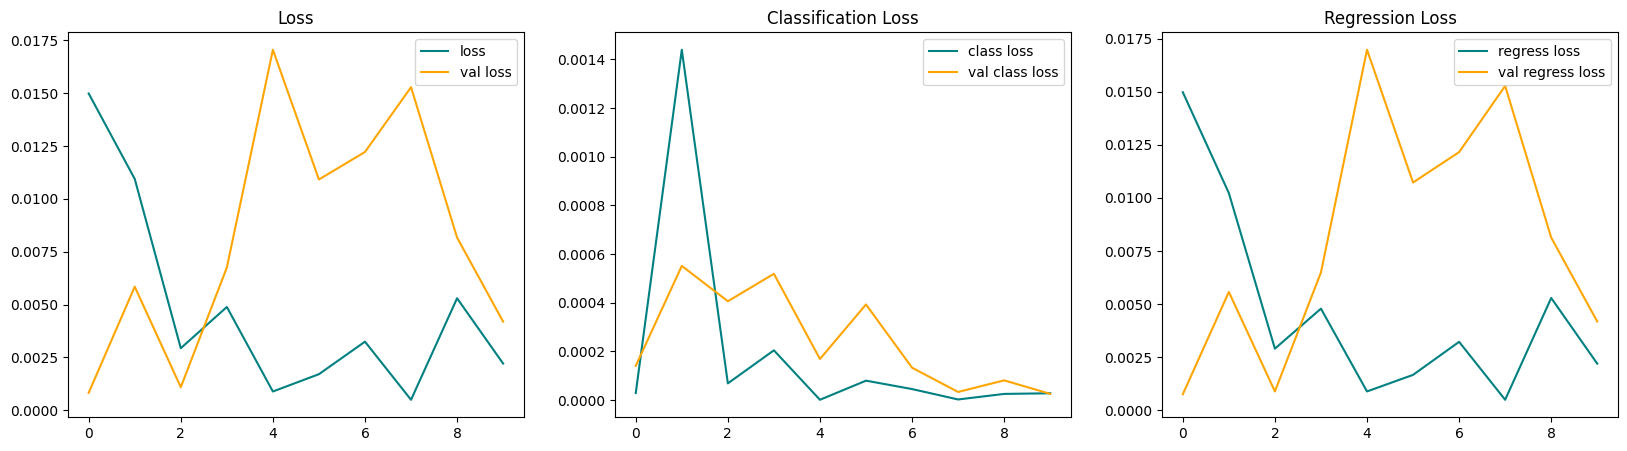

In [97]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


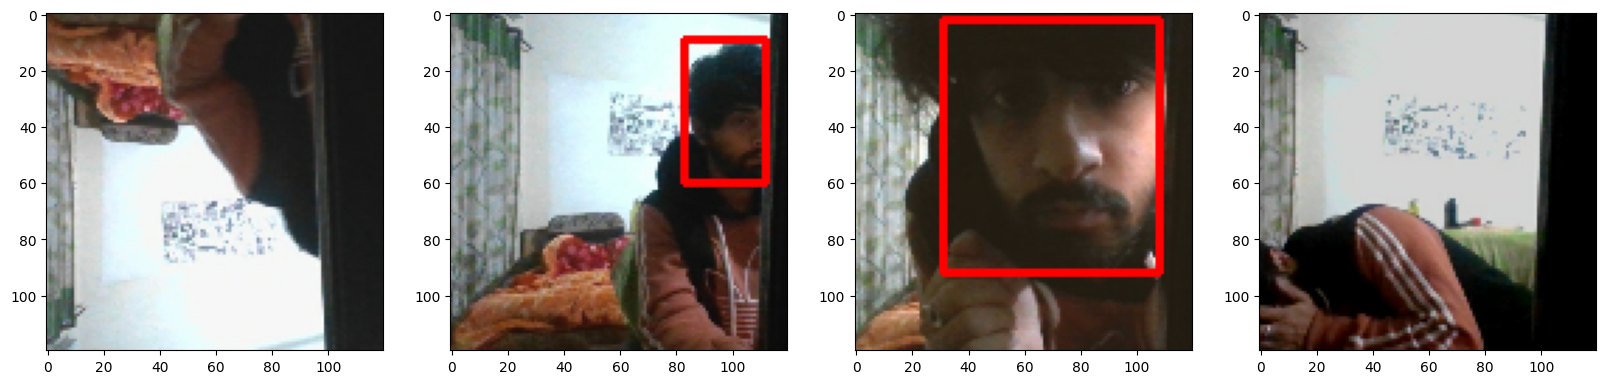

In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        # Convert NumPy array to cv::UMat
        sample_image_umat = cv2.UMat(sample_image)

        # Draw rectangle
        cv2.rectangle(sample_image_umat,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

        # Convert back to NumPy array for displaying with matplotlib
        sample_image_with_rect = np.asarray(sample_image_umat.get())

        ax[idx].imshow(sample_image_with_rect)
    else:
        ax[idx].imshow(sample_image)

plt.show()


In [100]:
# Save the Model

from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

c:\Users\Arsh Bhushan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [102]:
#Real Time Detection


cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 53ms/step


KeyboardInterrupt: 